In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

torch.cuda.set_device(4)
torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.transformer_wrapper import FairseqTransformerHub

import alignment.align as align

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from collections import defaultdict
import statistics

import logging
logger = logging.getLogger()

logger.setLevel('WARNING')
warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [3]:
data_sample = 'interactive' # generate/interactive
teacher_forcing = False # teacher forcing/free decoding

green_color = '#82B366'
red_color = '#B85450'

In [4]:
# Paths
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
#iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

# Choose model
model_type = 'baseline'
seed = 5498 # 2253  2453  5498  9240	9819

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(), 
)
NUM_LAYERS = 6


## Get sample for analysis

In [5]:
# Get sample from provided test data

if data_sample == 'generate':
    i = 386  # 0, 1 28, 45, 148 (pred_tok vs tgt_tok), 178, 16 (Hallucination), 421 (Hallucination)

    src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('test', i)
    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")

In [28]:
test_set_dir = europarl_dir / "processed_data/"
src = "de"
tgt = "en"
tokenizer = "bpe"

for i in range(508):
    # index in dataset
    src_word_sent, src_tok, src_tok_str, src_tensor, tgt_word_sent, tgt_tok, tgt_tok_str, tgt_tensor = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=True)
    if src_tensor.size(0) <10:
        print(i)
        print(src_word_sent)
        print(tgt_word_sent)

1
das stimmt nicht !

but this is not what happens .

8
das protokoll der gestrigen sitzung wurde verteilt .

the minutes of yesterday 's sitting have been distributed .

14
sie versanden .

they are silting up .

33
die kommission hat diesen appell vernommen .

the commission heeded this call .

43
deshalb besteht die notwendigkeit einer europäischen richtlinie .

therefore there is a need for a european directive .

65
gibt es einwände ?

are there any other comments ?

77
zur empfehlung für die zweite lesung meier

meier recommendation for second reading

83
natürlich gibt es da einen unterschied .

of course there is a difference .

86
das ist der punkt !

this is the whole point !

87
eine entsprechende änderung wird vorgenommen werden .

the necessary correction will be made .

105
wir benötigen detaillierte , konkrete vorschläge .

we need detailed , concrete proposals .

121
aber das hat leider tradition !

but that unfortunately has become a tradition !

130
sicher nicht .

su

In [152]:
if data_sample == 'interactive':
    # Get sample from Gold alignment dataset

    # index in dataset
    i = 3 # index in dataset
    # 3, 100, 105, 107, 120 (example paper), 163 (error visible)
    test_set_dir = europarl_dir / "processed_data/"
    src = "de"
    tgt = "en"
    tokenizer = "bpe"
    src_word_sent, src_tok, src_tok_str, src_tensor, tgt_word_sent, tgt_tok, tgt_tok_str, tgt_tensor = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)

    print(src_word_sent)
    print(tgt_word_sent)

herr kommissar , liebe kolleginnen und kollegen ! zunächst herzlichen dank , herr burtone , für ihren bericht .

commissioner , ladies and gentlemen , i should like to begin by thanking mr burtone for his report .



## Test set analysis

### Encoder output representations mixing

In [120]:
test_set_dir = europarl_dir / "processed_data/"
src = "de"
tgt = "en"
tokenizer = "bpe"

results_dict = defaultdict(list)

for i in range(508):
    # index in dataset
    src_word_sent, src_tok, src_tok_str, src_tensor, tgt_word_sent, tgt_tok, tgt_tok_str, tgt_tensor = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)
    if len(src_tok)>20 and len(src_tok)<23:
        relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn']
        results_dict['means'].append(torch.diagonal(relevances_enc_self_attn[-1]).mean().detach().item())
        results_dict['stds'].append(torch.diagonal(relevances_enc_self_attn[-1]).std().detach().item())

In [121]:

total_sentences = len(results_dict['means'])
print(f'Total of {total_sentences} sentences')
print('Mean: ', statistics.mean(results_dict['means']))
print('Std: ', statistics.mean(results_dict['stds']))

Total of 39 sentences
Mean:  0.3910024846211458
Std:  0.19302802857680199


## Hallucinations Analysis

In [ ]:
for i in range(508):
    # index in dataset
    src_word_sent, src_tok, src_tok_str, src_tensor, tgt_word_sent, tgt_tok, tgt_tok_str, tgt_tensor = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)
    prefix_tokens = torch.tensor([[3]]).to('cuda')
    total_alti = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total']
    
        

In [153]:
if not teacher_forcing:
    tgt_tensor_free = []
    # prefix_tokens = ['</s>','</s>','</s>']
    # eos_id = hub.task.tgt_dict.eos_index # EOS token index
    # prefix_tokens = torch.tensor([eos_id] + [hub.tgt_dict.index(t) for t in prefix_tokens])

    prefix_tokens = torch.tensor([[3]]).to('cuda')
    inference_step_args={'prefix_tokens': prefix_tokens}

    print("\n\nBEAM SEARCH\n")
    for pred in hub.generate(src_tensor, 1, inference_step_args = inference_step_args):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.tgt_dict.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    tgt_tok = hub.decode(tgt_tensor, hub.task.tgt_dict, as_string=False)
    target_sentence = tgt_tok
    source_sentence = src_tok

    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
    pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")
    predicted_sentence = pred_tok



BEAM SEARCH

-1.2187076807022095 	 <unk>ατhe committee on foreign affairs , human rights , common security and defence policy ( cdb ) .


GREEDY DECODING with hypothesis 1

Predicted sentence: 	 mrατhe committee on foreign affairs , human rights , common security and defence policy ( cdb ) .


In [155]:
i = 3
#src_word_sent, src_tok, src_tok_str, src_tensor, tgt_word_sent, tgt_tok, tgt_tok_str, tgt_tensor = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)
# prefix_tokens = torch.tensor([[3]]).to('cuda')
# tgt_tensor = torch.cat([torch.tensor([hub.task.tgt_dict.eos_index, prefix_tokens]).to(tgt_tensor.device),
#                 tgt_tensor[2:]
#             ]).to(tgt_tensor.device)
total_alti = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total']

## Generate Translations

In [14]:
def get_translation(sample, prefix_tokens=None):
    """Get translation and total source contribution by ALTI"""
    
    inference_step_args={'prefix_tokens': prefix_tokens}
    # Get sample from test set
    sample = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer)
    src_tensor = sample['src_tensor']
    tgt_tensor_free = []
    # Compute beam search (beam = 1 greedy decoding)
    for pred in hub.generate(src_tensor, 1, inference_step_args = inference_step_args):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
        score = pred['score'].item()
        #print(f"{score} \t {pred_sent}")
        

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.tgt_dict.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)

    total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total'].detach()
    # Get total source contribution
    src_total_alti = total_rollout[-1][:,:src_tensor.size(0)].sum(dim=-1)
    # We delete the first prediction (only source and bos contribution)
    src_total_alti = src_total_alti[1:]

    return pred_sent, src_total_alti


In [62]:
test_set_dir = europarl_dir / "processed_data/"
src = "de"
tgt = "en"
tokenizer = "bpe"
standard_translation = open('results/translations.txt', 'w', encoding="utf-8")
perturbed_translation = open('results/translations_unk.txt', 'w', encoding="utf-8")
src_alti_perturbed_list = []
src_alti_list = []

for i in range(508):
    #inference_step_args = None
    get_translation(sample, prefix_tokens=None)

    
    sample = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer)

    # Standard translation
    pred_sent, src_total_alti  = get_translation(sample, prefix_tokens=None)
    standard_translation.write(pred_sent + '\n')
    src_alti_list.append(src_total_alti.tolist())

    # Perturbed translation
    prefix_tokens = torch.tensor([[3]]).to('cuda')
    pred_sent_perturbed, src_alti_perturbed  = get_translation(sample, prefix_tokens=prefix_tokens)
    perturbed_translation.write(pred_sent_perturbed + '\n')
    
    src_alti_perturbed_list.append(src_alti_perturbed.tolist())

standard_translation.close()
perturbed_translation.close()

In [68]:
import csv

with open('results/src_alti.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(src_alti_list)

with open('results/src_alti_unk.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(src_alti_perturbed_list)

In [63]:
#import sacrebleu
from sacrebleu.metrics import BLEU, CHRF, TER
import nltk
bleu = BLEU(max_ngram_order=4)
def compute_bleu(reference, candidate):
    return bleu.corpus_score([candidate],[[reference]]).score

def read_file(path):
    with open(path,'r') as f:
        return list(f.readlines())
#compute BLEU score against the reference for each baseline and model output
refs = []
model_translations = []
hallucinations = []
refs.append(read_file("data/de-en/test.en"))
model_translations.append(read_file("results/translations.txt"))
hallucinations.append(read_file("results/translations_unk.txt"))
diff_score = []
scores = []

for i in range(len(refs[0])):# len(refs[0])
    model_score = sum([compute_bleu(refs[j][i],model_translations[j][i]) for j in range(len(model_translations))])/len(model_translations)
    hallucinations_score = sum([compute_bleu(refs[j][i],hallucinations[j][i]) for j in range(len(hallucinations))])/len(hallucinations)
    diff_score.append((i,model_score-hallucinations_score))
    scores.append((i, model_score, hallucinations_score))
    #print('Computed score', i, model_score, hallucinations_score)
    #print('Computed score', i, model_score)

In [78]:
# Apply algorithm for extracting hallucination
hallucination_set = []
for (i, model_score, hallucinations_score) in scores:
    if model_score > 0.2:
        if hallucinations_score < 0.05:
            hallucination_set.append(i)

In [84]:
hallucination_set

[3,
 26,
 65,
 92,
 95,
 96,
 103,
 118,
 131,
 184,
 196,
 224,
 239,
 253,
 269,
 272,
 282,
 283,
 320,
 327,
 335,
 348,
 355,
 368,
 371,
 387,
 408,
 419,
 451,
 457,
 466,
 469]

[Text(0, 0, 'Unperturbed'), Text(0, 0, 'Perturbed')]

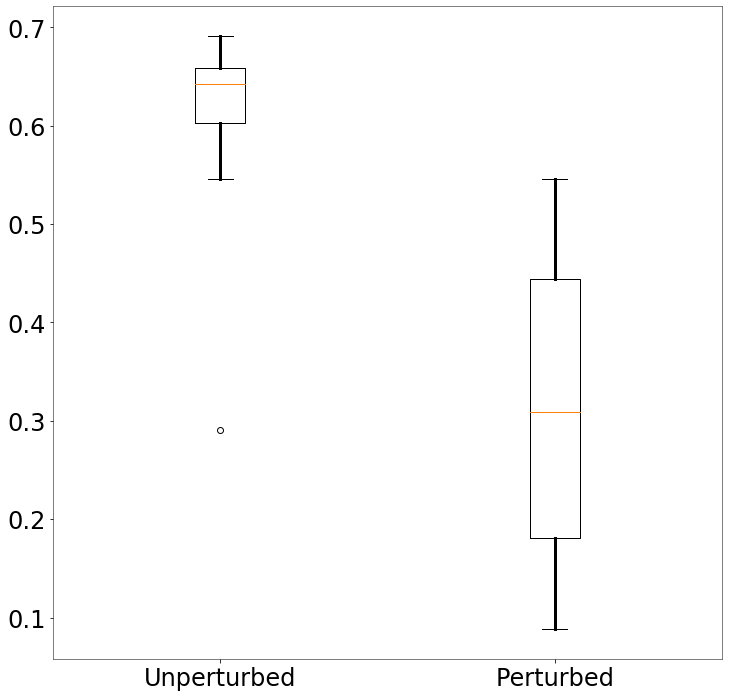

In [83]:
mean_src_alti = []
mean_preturbed_src_alti = []
mean_alti = defaultdict(list)
for i in hallucination_set:
    mean_alti['Unperturbed'].append(statistics.mean(src_alti_list[i]))
    mean_alti['Perturbed'].append(statistics.mean(src_alti_perturbed_list[i]))

fig, ax = plt.subplots()
ax.boxplot(mean_alti.values(),whiskerprops=dict(linewidth=3.0))
ax.set_xticklabels(mean_alti.keys())